# **Lunar Lander**

In [1]:
from stable_baselines3 import DQN, A2C
import gymnasium as gym
from stable_baselines3.common.logger import configure
from stable_baselines3.common.evaluation import evaluate_policy
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os
import glob
import seaborn as sns

2025-04-03 13:35:43.316818: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-03 13:35:43.462842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743698143.521091    5516 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743698143.537833    5516 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-03 13:35:43.678318: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# **A2C**

In [2]:
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
tmp_path = f"./results/lunar_lander/A2C_run_{run_id}"
new_logger = configure(tmp_path, ["stdout", "csv"])

env = gym.make("LunarLander-v3")

model = A2C(
    policy="MlpPolicy",
    env=env,
    device="cpu",
    learning_rate=7e-4,          # slightly lower than DQN
    n_steps=16,                   # put 16 because it was plateauing
    gamma=0.99,
    gae_lambda=0.95,
    ent_coef=0.01,               # encourage exploration
    vf_coef=0.5,
    max_grad_norm=0.5,
    use_rms_prop=True,
    normalize_advantage=True
)

# Uncomment this line if you want to keep training an old model
#model = A2C.load("./model/A2C_LunarLander")
#model.set_env(env)

model.set_logger(new_logger)
model.learn(total_timesteps=1e6)

mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

print('modelo treinado')

Logging to ./results/lunar_lander/A2C_run_20250403_133604
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 103      |
|    ep_rew_mean        | -336     |
| time/                 |          |
|    fps                | 627      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 1600     |
| train/                |          |
|    entropy_loss       | -1.14    |
|    explained_variance | -0.053   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.0804  |
|    value_loss         | 87.7     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 122      |
|    ep_rew_mean        | -433     |
| time/                 |          |
|    fps                | 961      |
|    iterations         | 200      |
|    time_elapsed       | 3        |
|    total_timest

In [3]:
env = gym.make("LunarLander-v3", render_mode='human')
(obs,_) = env.reset()
for i in range(1000):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    env.render()
    if done:
      obs = env.reset()
      break

In [3]:
model.save("./model/A2C_LunarLander")

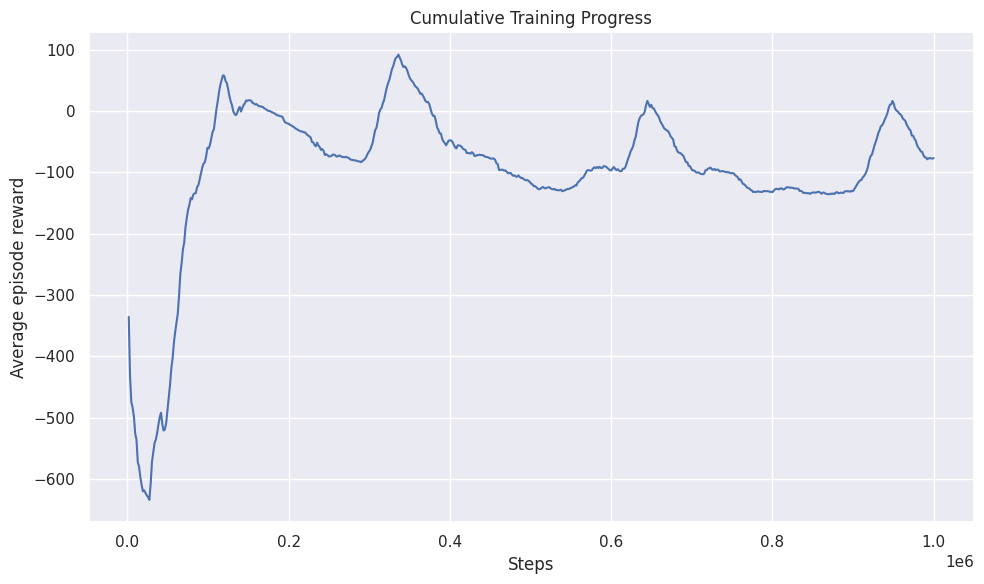

In [11]:
sns.set_theme(style="darkgrid")

# Get all progress.csv files from sorted run folders
base_path = "results/lunar_lander/"
csv_paths = sorted(glob.glob(os.path.join(base_path, "A2C_run_*/progress.csv")))

all_dfs = []
total_timesteps_offset = 0

for path in csv_paths:
    df = pd.read_csv(path)

    # Adjust total_timesteps to be cumulative
    df['time/total_timesteps'] += total_timesteps_offset
    total_timesteps_offset = df['time/total_timesteps'].iloc[-1]

    all_dfs.append(df)

# Concatenate the adjusted data
combined_df = pd.concat(all_dfs, ignore_index=True)

# Plot as a single line
plt.figure(figsize=(10, 6))
plt.plot(combined_df['time/total_timesteps'], combined_df['rollout/ep_rew_mean'])
plt.xlabel('Steps')
plt.ylabel('Average episode reward')
plt.title('Cumulative Training Progress')
plt.grid(True)
plt.tight_layout()
plt.show()

# **DQN**

In [5]:
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
tmp_path = f"./results/lunar_lander/DQN_run_{run_id}"
new_logger = configure(tmp_path, ["stdout", "csv"])

env = gym.make("LunarLander-v3")
model = DQN(
    policy = "MlpPolicy",
    env = env,
    device="cpu",
    learning_rate=0.001,
    buffer_size=10_000,
    batch_size=64,
    gamma=0.99,
    target_update_interval=100,
    exploration_fraction=0.0067, # Explicar aqui que na vdd isso é outra coisa mas funcionou igual
    exploration_initial_eps=1.0,
    exploration_final_eps=0.01   
)

# Uncomment this line if you want to keep training an old model
#model = DQN.load("./model/DQN_LunarLander")
#model.set_env(env)

model.set_logger(new_logger)
model.learn(total_timesteps=1e6)

mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

print('modelo treinado')

Logging to ./results/lunar_lander/DQN_run_20250403_134352
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 96.8     |
|    ep_rew_mean      | -281     |
|    exploration_rate | 0.943    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2630     |
|    time_elapsed     | 0        |
|    total_timesteps  | 387      |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.04     |
|    n_updates        | 71       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.6     |
|    ep_rew_mean      | -188     |
|    exploration_rate | 0.883    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2609     |
|    time_elapsed     | 0        |
|    total_timesteps  | 789      |
| train/              |          |
|    learning_rate    | 0.001   

In [24]:
env = gym.make("LunarLander-v3", render_mode='human')
(obs,_) = env.reset()
for i in range(1000):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    env.render()
    if done:
      obs = env.reset()
      break

In [6]:
model.save("./model/DQN_LunarLander")

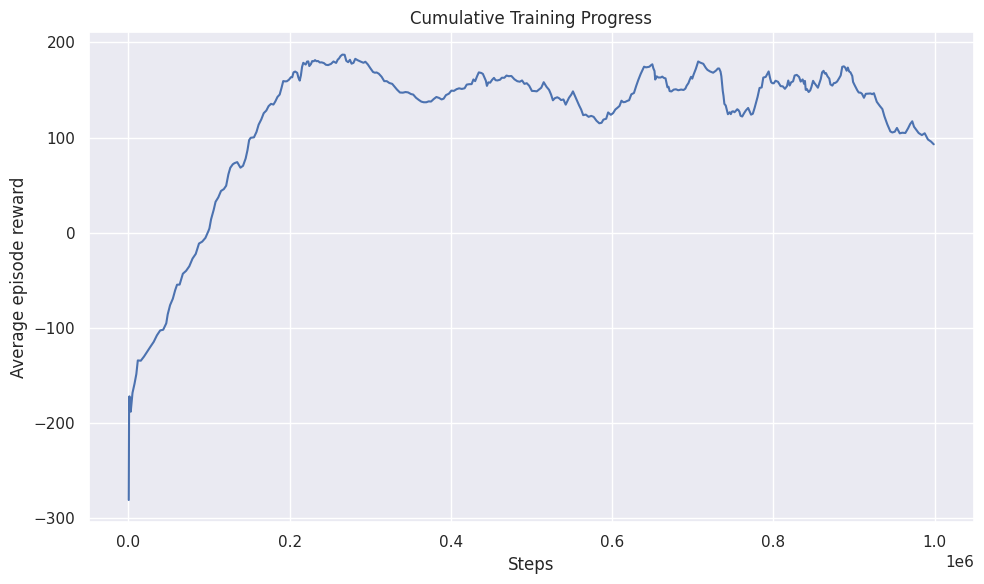

In [10]:
sns.set_theme(style="darkgrid")

# Get all progress.csv files from sorted run folders
base_path = "results/lunar_lander/"
csv_paths = sorted(glob.glob(os.path.join(base_path, "DQN_run_*/progress.csv")))

all_dfs = []
total_timesteps_offset = 0

for path in csv_paths:
    df = pd.read_csv(path)

    # Adjust total_timesteps to be cumulative
    df['time/total_timesteps'] += total_timesteps_offset
    total_timesteps_offset = df['time/total_timesteps'].iloc[-1]

    all_dfs.append(df)

# Concatenate the adjusted data
combined_df = pd.concat(all_dfs, ignore_index=True)

# Plot as a single line
plt.figure(figsize=(10, 6))
plt.plot(combined_df['time/total_timesteps'], combined_df['rollout/ep_rew_mean'])
plt.xlabel('Steps')
plt.ylabel('Average episode reward')
plt.title('Cumulative Training Progress')
plt.grid(True)
plt.tight_layout()
plt.show()

# **Comparing the Models**

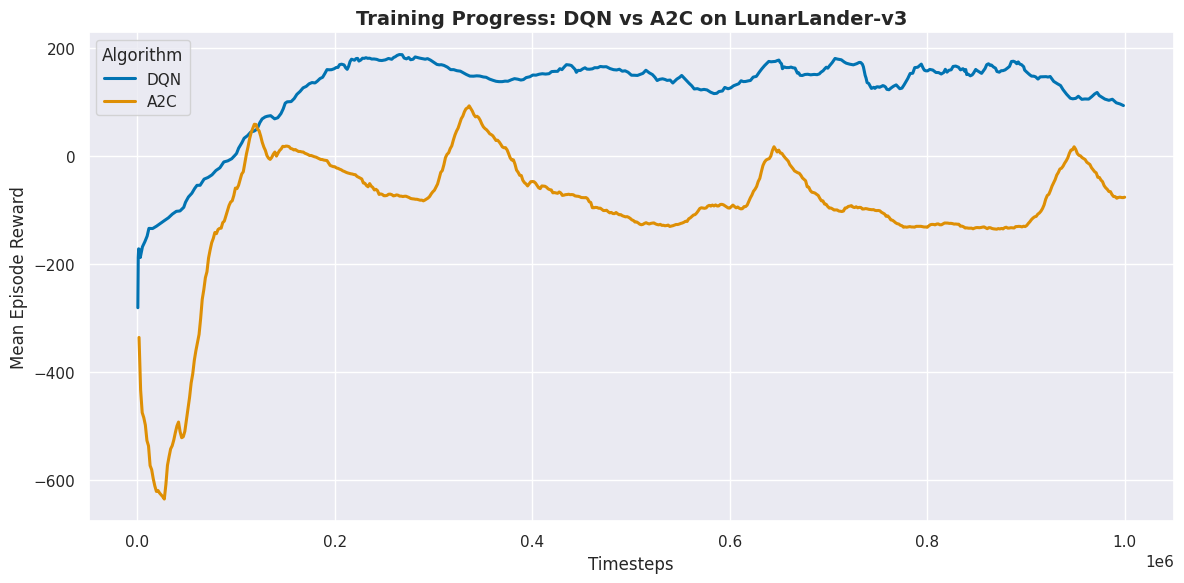

In [9]:
# Apply Seaborn theme
sns.set_theme(style="darkgrid")

def load_progress_curves(base_path: str, algo_prefix: str):
    csv_paths = sorted(glob.glob(os.path.join(base_path, f"{algo_prefix}_run_*/progress.csv")))
    all_dfs = []
    total_timesteps_offset = 0

    for path in csv_paths:
        df = pd.read_csv(path)
        if 'time/total_timesteps' not in df or 'rollout/ep_rew_mean' not in df:
            continue  # skip malformed logs

        df['Algorithm'] = algo_prefix  # Add a column for plotting
        df['time/total_timesteps'] += total_timesteps_offset
        total_timesteps_offset = df['time/total_timesteps'].iloc[-1]
        all_dfs.append(df)

    return pd.concat(all_dfs, ignore_index=True) if all_dfs else pd.DataFrame()

# Load both algorithms
base_path = "results/lunar_lander/"
dqn_df = load_progress_curves(base_path, "DQN")
a2c_df = load_progress_curves(base_path, "A2C")

# Combine both into one DataFrame
combined_df = pd.concat([dqn_df, a2c_df], ignore_index=True)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=combined_df,
    x='time/total_timesteps',
    y='rollout/ep_rew_mean',
    hue='Algorithm',
    palette='colorblind',
    linewidth=2.2
)
plt.xlabel('Timesteps', fontsize=12)
plt.ylabel('Mean Episode Reward', fontsize=12)
plt.title('Training Progress: DQN vs A2C on LunarLander-v3', fontsize=14, weight='bold')
plt.legend(title='Algorithm')
plt.tight_layout()
plt.show()